In [34]:
import sv_utils
import torch 
import numpy as np
import pylab as plt
from os.path import dirname, realpath
from singleNeuron import preSpikes, nextSpikes, STDPLIFDensePopulation

## Sequence Visualizer

El proposito de esta notebook es el poder graficar tanto la entrada como salida de la red DSNN que reconoce patrones en una secuencia de numeros aleatorios.

In [35]:
Sin_tmp = np.load('./sequences/seq_0.npy')
print(Sin_tmp.shape)
Sin = np.reshape(Sin_tmp, (Sin_tmp.shape[0]*Sin_tmp.shape[1], Sin_tmp.shape[2]))
Sin = np.transpose(Sin)
print(Sin.shape)

(34, 34, 34900)
(34900, 1156)


### Tren de spikes de entrada

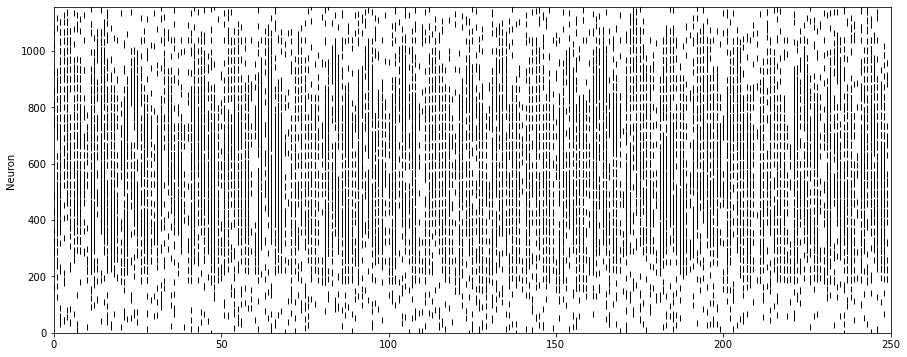

3353984

In [36]:
plt.rcParams["figure.figsize"] =(15,6)
sv_utils.plotLIF(U=None, S=Sin[:250])
np.count_nonzero(Sin)

### Tren de spikes de salida

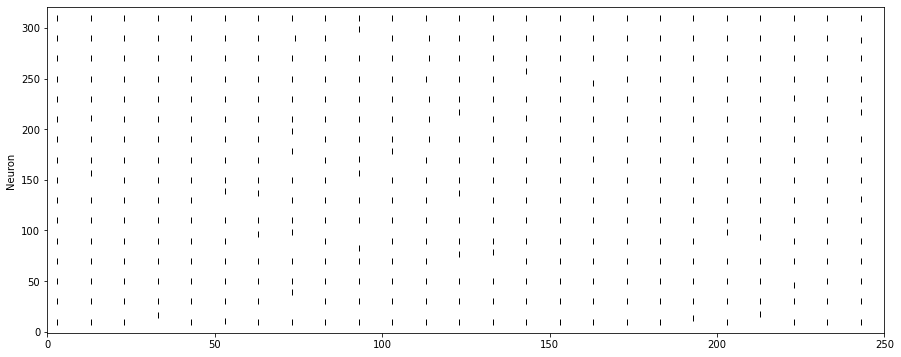

torch.Size([68000, 320])


108800

In [37]:
Sin_out = torch.load('../SDNN-Maxi/results/Sin-out.pt')
sv_utils.plotLIF(U=None, S=Sin_out[:250].data.numpy())
print(Sin_out.shape)
np.count_nonzero(Sin_out)

In [13]:
Sprobe = torch.load('../SDNN-Maxi/results/Sprobe.pt')
Uprobe = torch.load('../SDNN-Maxi/results/Uprobe.pt')
pat_times = np.load('./sequences/pat_i_0.npy')
print(Sprobe.shape)

(34000, 1)


### Potencial de membrana de salida

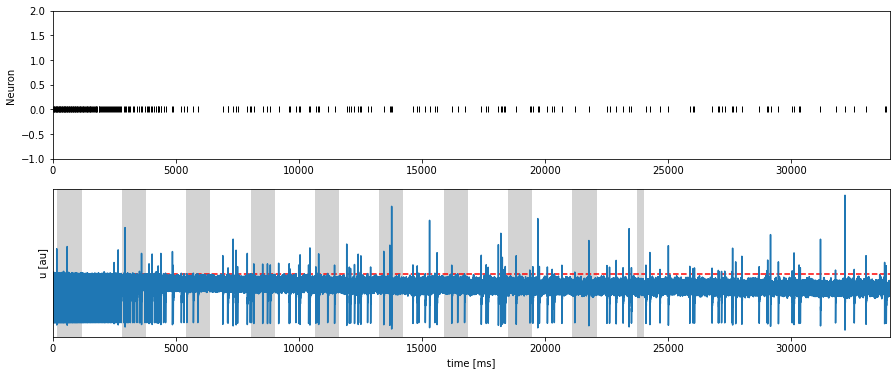

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [14]:
sv_utils.plotLIF(U=Uprobe, S=Sprobe, pat_times=pat_times, th=25.)

## Entrenamos a la neurona de salida

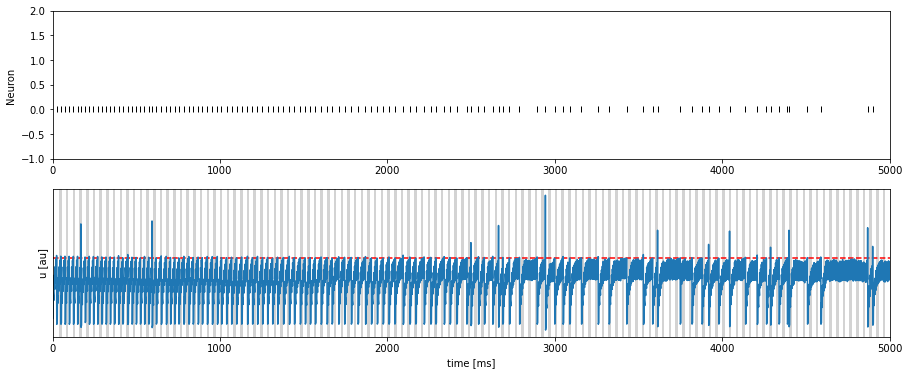

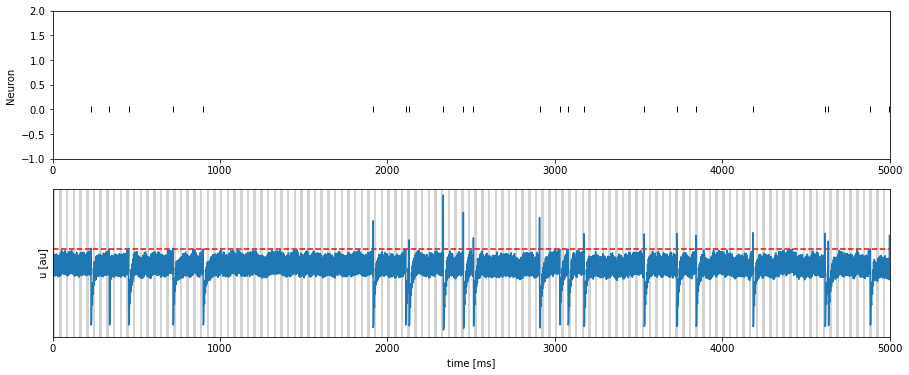

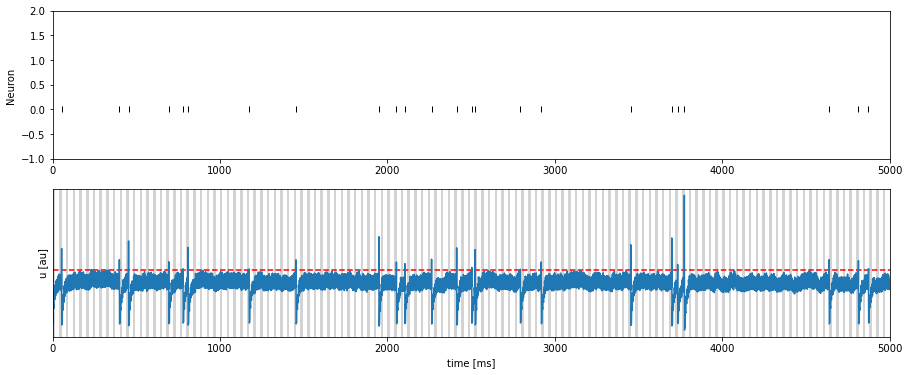

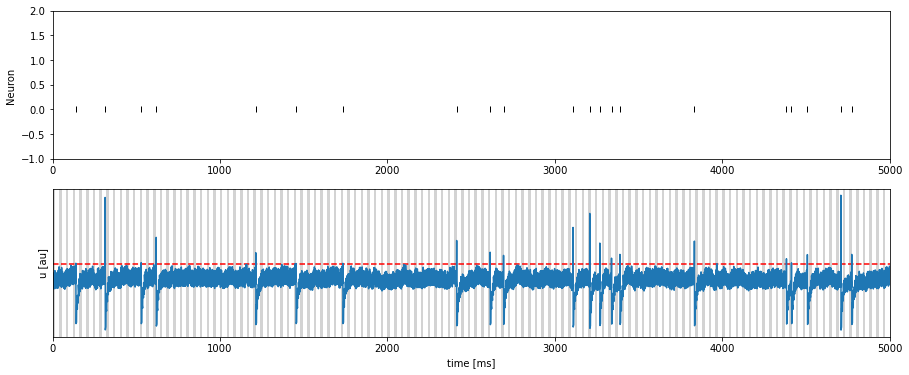

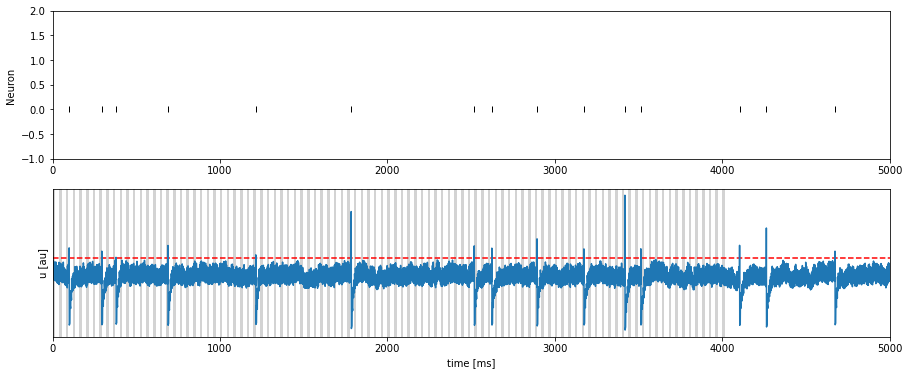

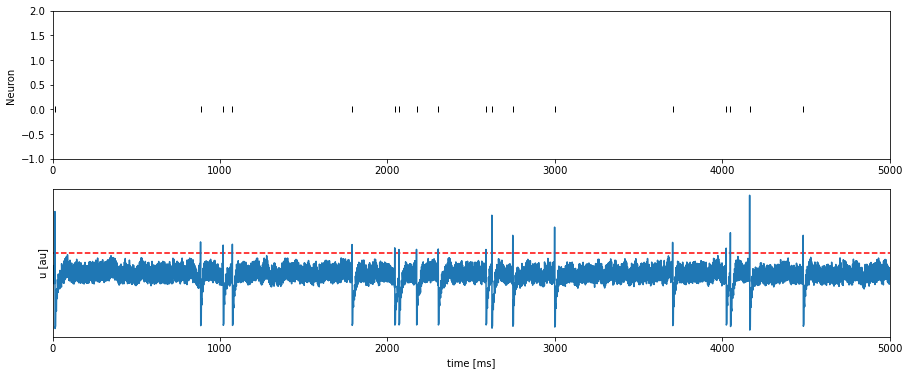

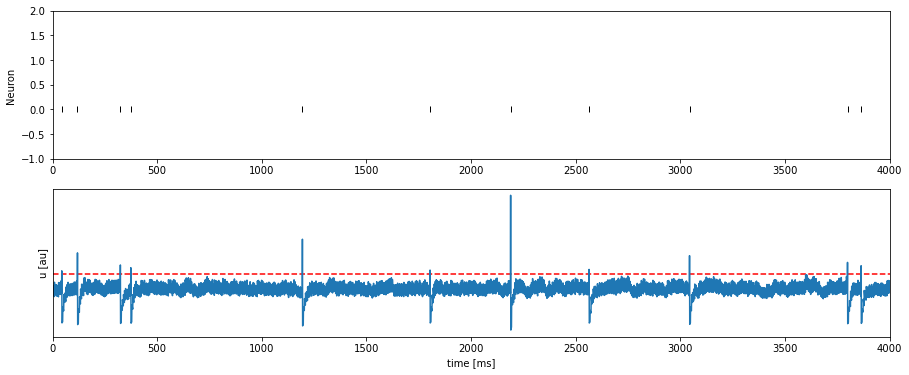

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [33]:
Sin_tmp = Sin_out.clone().detach()
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.7, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=25., a_plus=0.003125, a_minus=0.00865625,
                                        w_max=1.)
Sin = Sin_tmp.clone().detach()

# Pre-procesamos PSpikes y NSpikes
dt_ltp = 5   # Cantidad de timesteps que miro hacia atras
dt_ltd = 10  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()

sv_utils.plotLIF(U=Uprobe[0:5000], S=Sprobe[0:5000], pat_times=pat_times[0:5000], th=25.)
sv_utils.plotLIF(U=Uprobe[5000:10000], S=Sprobe[5000:10000], pat_times=pat_times[5000:10000], th=25.)
sv_utils.plotLIF(U=Uprobe[10000:15000], S=Sprobe[10000:15000], pat_times=pat_times[10000:15000], th=25.)
sv_utils.plotLIF(U=Uprobe[15000:20000], S=Sprobe[15000:20000], pat_times=pat_times[15000:20000], th=25.)
sv_utils.plotLIF(U=Uprobe[20000:25000], S=Sprobe[20000:25000], pat_times=pat_times[20000:25000], th=25.)
sv_utils.plotLIF(U=Uprobe[25000:30000], S=Sprobe[25000:30000], pat_times=pat_times[25000:30000], th=25.)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=25.)